# Download data(skip if data already downloaded)

In [10]:
import requests, pandas as pd
from datetime import datetime, timedelta, timezone
import time

API_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"

def fetch_usgs_quakes(start, end, minmag=5.0, limit=20000,
                      bbox=None, circle=None, orderby="time"):
    """
    start/end: timezone-aware datetime (UTC 권장)
    minmag: 최소 규모
    limit: 최대 20000 (USGS 서비스 제한)
    bbox: (minlat, minlon, maxlat, maxlon)  # 사각형 검색
    circle: (lat, lon, maxradius_km)        # 원 범위 검색
    orderby: 'time' | 'time-asc' | 'magnitude' | 'magnitude-asc'
    """
    params = {
        "format": "geojson",
        "starttime": start.isoformat(timespec="seconds"),
        "endtime": end.isoformat(timespec="seconds"),
        "minmagnitude": minmag,
        "limit": limit,
        "orderby": orderby
    }
    if bbox:
        minlat, minlon, maxlat, maxlon = bbox
        params.update({
            "minlatitude": minlat, "minlongitude": minlon,
            "maxlatitude": maxlat, "maxlongitude": maxlon
        })
    if circle:
        lat, lon, r_km = circle
        params.update({"latitude": lat, "longitude": lon, "maxradiuskm": r_km})

    r = requests.get(API_URL, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    rows = []
    for f in data.get("features", []):
        props = f.get("properties", {})
        # coordinates = [lon, lat, depth(km)]
        lon, lat, depth_km = f["geometry"]["coordinates"]
        rows.append({
            "time_utc": pd.to_datetime(props.get("time"), unit="ms", utc=True),
            "mag": props.get("mag"),
            "place": props.get("place"),
            "lat": lat, "lon": lon, "depth_km": depth_km,
            "id": f.get("id"), "detail_url": props.get("url")
        })
    return pd.DataFrame(rows)

In [2]:
# 예시 1: 전 세계, 지난 7일, M5.0+
df_world = pd.DataFrame()
dend = 50
end = datetime.now(timezone.utc)
start = end - timedelta(days=dend)

dp = 10
for d in range(0,dend,dp):
    dateFrom = start + timedelta(days=d)
    dateTo = start + timedelta(days=d+dp)
    df_world_ = fetch_usgs_quakes(dateFrom, dateTo, minmag=1.0)
    if df_world_.shape[0]==20000:
        print('Not enough',dateFrom,dateTo)
    df_world = pd.concat((df_world,df_world_),axis=0).reset_index(drop=True)
    time.sleep(2)
print(df_world.shape)
df_world.to_csv("usgs_quakes_last50d_M3+_251117.csv", index=False)


(9606, 8)


In [ ]:
# 예시 2: 한반도 주변(대충 잡은 BBOX), 지난 30일, M3.0+
bbox_korea = (20.0, 110.0, 46.0, 150.0)  # (minlat, minlon, maxlat, maxlon)
df_korea = fetch_usgs_quakes(end - timedelta(days=365*5), end,
                                minmag=1.0, bbox=bbox_korea)
#print(df_korea.describe(include="all"))
print(df_korea.shape)

# 저장
df_korea.to_csv("usgs_quakes_korea_last180d_M1+_250929.csv", index=False)
print("CSV saved.")


                                   time_utc          mag  \
count                                  8093  8093.000000   
unique                                  NaN          NaN   
top                                     NaN          NaN   
freq                                    NaN          NaN   
mean    2023-04-16 12:44:49.169042944+00:00     4.496404   
min        2020-10-02 12:15:00.969000+00:00     3.000000   
25%        2022-02-26 10:08:38.216000+00:00     4.300000   
50%     2023-05-18 10:06:41.384999936+00:00     4.400000   
75%     2024-04-26 12:28:12.817999872+00:00     4.600000   
max        2025-09-29 17:28:03.902000+00:00     7.500000   
std                                     NaN     0.371764   

                            place          lat         lon     depth_km  \
count                        8062  8093.000000  8093.00000  8093.000000   
unique                       4607          NaN         NaN          NaN   
top     Izu Islands, Japan region          NaN        

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [3]:
df_world = pd.read_csv("usgs_quakes_last1080d_M3+_250929.csv")
df_world2 = pd.read_csv("usgs_quakes_last50d_M3+_251117.csv")
print(df_world.shape,df_world2.shape)
df_world = pd.concat((df_world,df_world2),axis=0)
print(df_world.shape,df_world2.shape)
df_world = df_world.drop_duplicates().reset_index(drop=True)
df_world.shape

(306544, 8) (9606, 8)
(316150, 8) (9606, 8)


(315827, 8)

In [4]:
# df_world = pd.read_csv("usgs_quakes_last180d_M3+250929.csv")

df_world['time_utc'] = pd.to_datetime(df_world['time_utc'].str.slice(0,-6), format="%Y-%m-%d %H:%M:%S.%f", errors="coerce", utc=True)

lats = np.deg2rad(df_world['lat'].values)
lons = np.deg2rad(df_world['lon'].values)

df_world['x'] = np.cos(lats) * np.cos(lons)
df_world['y'] = np.cos(lats) * np.sin(lons)
df_world['z'] = np.sin(lats)

In [6]:
import geomstats.backend as gs
import geomstats.errors as error
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian

from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import (
    SPDMatrices,
    SPDAffineMetric,
    SPDLogEuclideanMetric,
    SPDBuresWassersteinMetric
)
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian
import geomstats.visualization as visualization
from geomstats.visualization import Sphere


import os,sys
sys.path.append(os.path.join(os.getcwd(),'../..'))
import riemannian_robust_m_estimator as rrm


In [7]:
cities = [
    ("New York",        40.71,  -74.01),
    ("Washington DC",   38.90,  -77.04),
    ("London",          51.51,   -0.13),
    ("Paris",           48.85,    2.35),
    ("Berlin",          52.52,   13.40),
    ("Moscow",          55.76,   37.62),
    ("Beijing",         39.90,  116.40),
    ("Tokyo",           35.68,  139.76),
    ("Seoul",           37.57,  126.98),
    ("Singapore",        1.35,  103.82),
    ("Sydney",         -33.87,  151.21),
    ("Mumbai",          19.08,   72.88),
    # ("São Paulo",      -23.55,  -46.63),
    # ("Buenos Aires",   -34.61,  -58.38),
    ("Cape Town",      -33.93,   18.42),
    ("Nairobi",         -1.29,   36.82),
    ("Los Angeles",     34.05, -118.25),
    ("Chicago",         41.88,  -87.63),
    ("Mexico City",     19.43,  -99.13),
    # ("Lima",           -12.05,  -77.05),
    # ("Rio de Janeiro", -22.91,  -43.17),
    ("Lagos",            6.45,    3.39),
    ("Cairo",           30.04,   31.24),
    ("Istanbul",        41.01,   28.95),
    ("Dubai",           25.20,   55.27),
    ("New Delhi",       28.61,   77.21),
    ("Bangkok",         13.75,  100.50),
    ("Jakarta",         -6.21,  106.85),
    ("Melbourne",      -37.81,  144.96),
    ("Auckland",       -36.85,  174.76),
    ("Honolulu",        21.31, -157.86),
    ("Ankara",          39.93,   32.86),
]

# 라디안 변환
cities_rad = [(name,
               np.deg2rad(lat),
               np.deg2rad(lon)) for name, lat, lon in cities]

# S² 좌표 변환 (x,y,z)
points = []
names = []
for name, phi, lam in cities_rad:  # phi=위도(rad), lam=경도(rad)
    x = np.cos(phi) * np.cos(lam)
    y = np.cos(phi) * np.sin(lam)
    z = np.sin(phi)
    points.append([x, y, z])
    names.append(name)

points = np.array(points)

In [ ]:
# https://simplemaps.com/static/demos/resources/world-cities/world_cities.csv
cities_ = pd.read_csv('world_cities.csv')
phi = np.deg2rad(cities_['lat'])
lam = np.deg2rad(cities_['lng'])
cities_['x'] = np.cos(phi) * np.cos(lam)
cities_['y'] = np.cos(phi) * np.sin(lam)
cities_['z'] = np.sin(phi)
cities_1m = cities_[cities_['pop']>100000].reset_index(drop=True)
cities_1m['name'] = cities_1m['country']+'_'+cities_1m['city']

In [192]:
df_world.time_utc.min(),df_world.time_utc.max(), pd.cut(df_world.mag,20).value_counts()

(Timestamp('2022-10-16 02:59:54.223000+0000', tz='UTC'),
 Timestamp('2025-09-30 02:22:34.004000+0000', tz='UTC'),
 mag
 (0.992, 1.39]    80617
 (1.39, 1.78]     72361
 (1.78, 2.17]     53585
 (2.17, 2.56]     25114
 (4.12, 4.51]     24615
 (2.56, 2.95]     14427
 (4.51, 4.9]      10827
 (2.95, 3.34]      7846
 (3.73, 4.12]      7834
 (3.34, 3.73]      4036
 (4.9, 5.29]       3088
 (5.29, 5.68]      1381
 (5.68, 6.07]       505
 (6.07, 6.46]       186
 (6.46, 6.85]        65
 (6.85, 7.24]        37
 (7.24, 7.63]        15
 (7.63, 8.02]         4
 (8.41, 8.8]          1
 (8.02, 8.41]         0
 Name: count, dtype: int64)

# Set each time period for which to compute sample mean of

In [39]:
lastday = datetime.now(timezone.utc)-timedelta(days=7)  #datetime.now(timezone.utc)
maxd = 1130
dp = 45
for i,d in enumerate(range(0,maxd,dp)):
    dateFrom = lastday - timedelta(days=maxd-d)  
    dateTo = lastday - timedelta(days=maxd-d-dp)
    mask = (df_world['time_utc'] >= dateFrom) & (df_world['time_utc'] < dateTo) & (df_world.mag>=5)& (df_world.mag<=30)
    print(i,d,dateFrom,dateTo,mask.sum())

0 0 2022-10-07 05:44:55.416102+00:00 2022-11-21 05:44:55.416102+00:00 161
1 45 2022-11-21 05:44:55.416102+00:00 2023-01-05 05:44:55.416102+00:00 230
2 90 2023-01-05 05:44:55.416102+00:00 2023-02-19 05:44:55.416102+00:00 220
3 135 2023-02-19 05:44:55.416102+00:00 2023-04-05 05:44:55.416102+00:00 189
4 180 2023-04-05 05:44:55.416102+00:00 2023-05-20 05:44:55.416102+00:00 223
5 225 2023-05-20 05:44:55.416102+00:00 2023-07-04 05:44:55.416102+00:00 207
6 270 2023-07-04 05:44:55.416102+00:00 2023-08-18 05:44:55.416102+00:00 156
7 315 2023-08-18 05:44:55.416102+00:00 2023-10-02 05:44:55.416102+00:00 162
8 360 2023-10-02 05:44:55.416102+00:00 2023-11-16 05:44:55.416102+00:00 253
9 405 2023-11-16 05:44:55.416102+00:00 2023-12-31 05:44:55.416102+00:00 344
10 450 2023-12-31 05:44:55.416102+00:00 2024-02-14 05:44:55.416102+00:00 181
11 495 2024-02-14 05:44:55.416102+00:00 2024-03-30 05:44:55.416102+00:00 168
12 540 2024-03-30 05:44:55.416102+00:00 2024-05-14 05:44:55.416102+00:00 247
13 585 2024-0

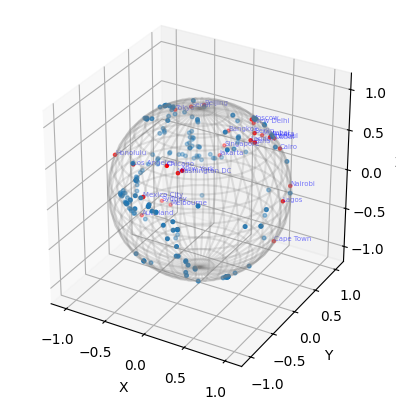

In [ ]:
ax = visualization.plot(gs.array(df_world_t.loc[:,['x','y','z']]),space='S2',s=7)
# 도시 점 찍기
ax.scatter(points[:,0], points[:,1], points[:,2],
        c="red", s=5, label="Major Cities")

# 도시 이름 라벨
for j, name in enumerate(names):
    ax.text(points[j,0], points[j,1], points[j,2],
            name, fontsize=5, color="blue",alpha=0.5)

0 0 2022-10-07 05:48:17.657775+00:00 2022-11-21 05:48:17.657775+00:00 161
1 45 2022-11-21 05:48:17.657775+00:00 2023-01-05 05:48:17.657775+00:00 230
2 90 2023-01-05 05:48:17.657775+00:00 2023-02-19 05:48:17.657775+00:00 220
3 135 2023-02-19 05:48:17.657775+00:00 2023-04-05 05:48:17.657775+00:00 189
4 180 2023-04-05 05:48:17.657775+00:00 2023-05-20 05:48:17.657775+00:00 223
5 225 2023-05-20 05:48:17.657775+00:00 2023-07-04 05:48:17.657775+00:00 207
6 270 2023-07-04 05:48:17.657775+00:00 2023-08-18 05:48:17.657775+00:00 156
7 315 2023-08-18 05:48:17.657775+00:00 2023-10-02 05:48:17.657775+00:00 162
8 360 2023-10-02 05:48:17.657775+00:00 2023-11-16 05:48:17.657775+00:00 253
9 405 2023-11-16 05:48:17.657775+00:00 2023-12-31 05:48:17.657775+00:00 344
10 450 2023-12-31 05:48:17.657775+00:00 2024-02-14 05:48:17.657775+00:00 181
11 495 2024-02-14 05:48:17.657775+00:00 2024-03-30 05:48:17.657775+00:00 168
12 540 2024-03-30 05:48:17.657775+00:00 2024-05-14 05:48:17.657775+00:00 247
13 585 2024-0

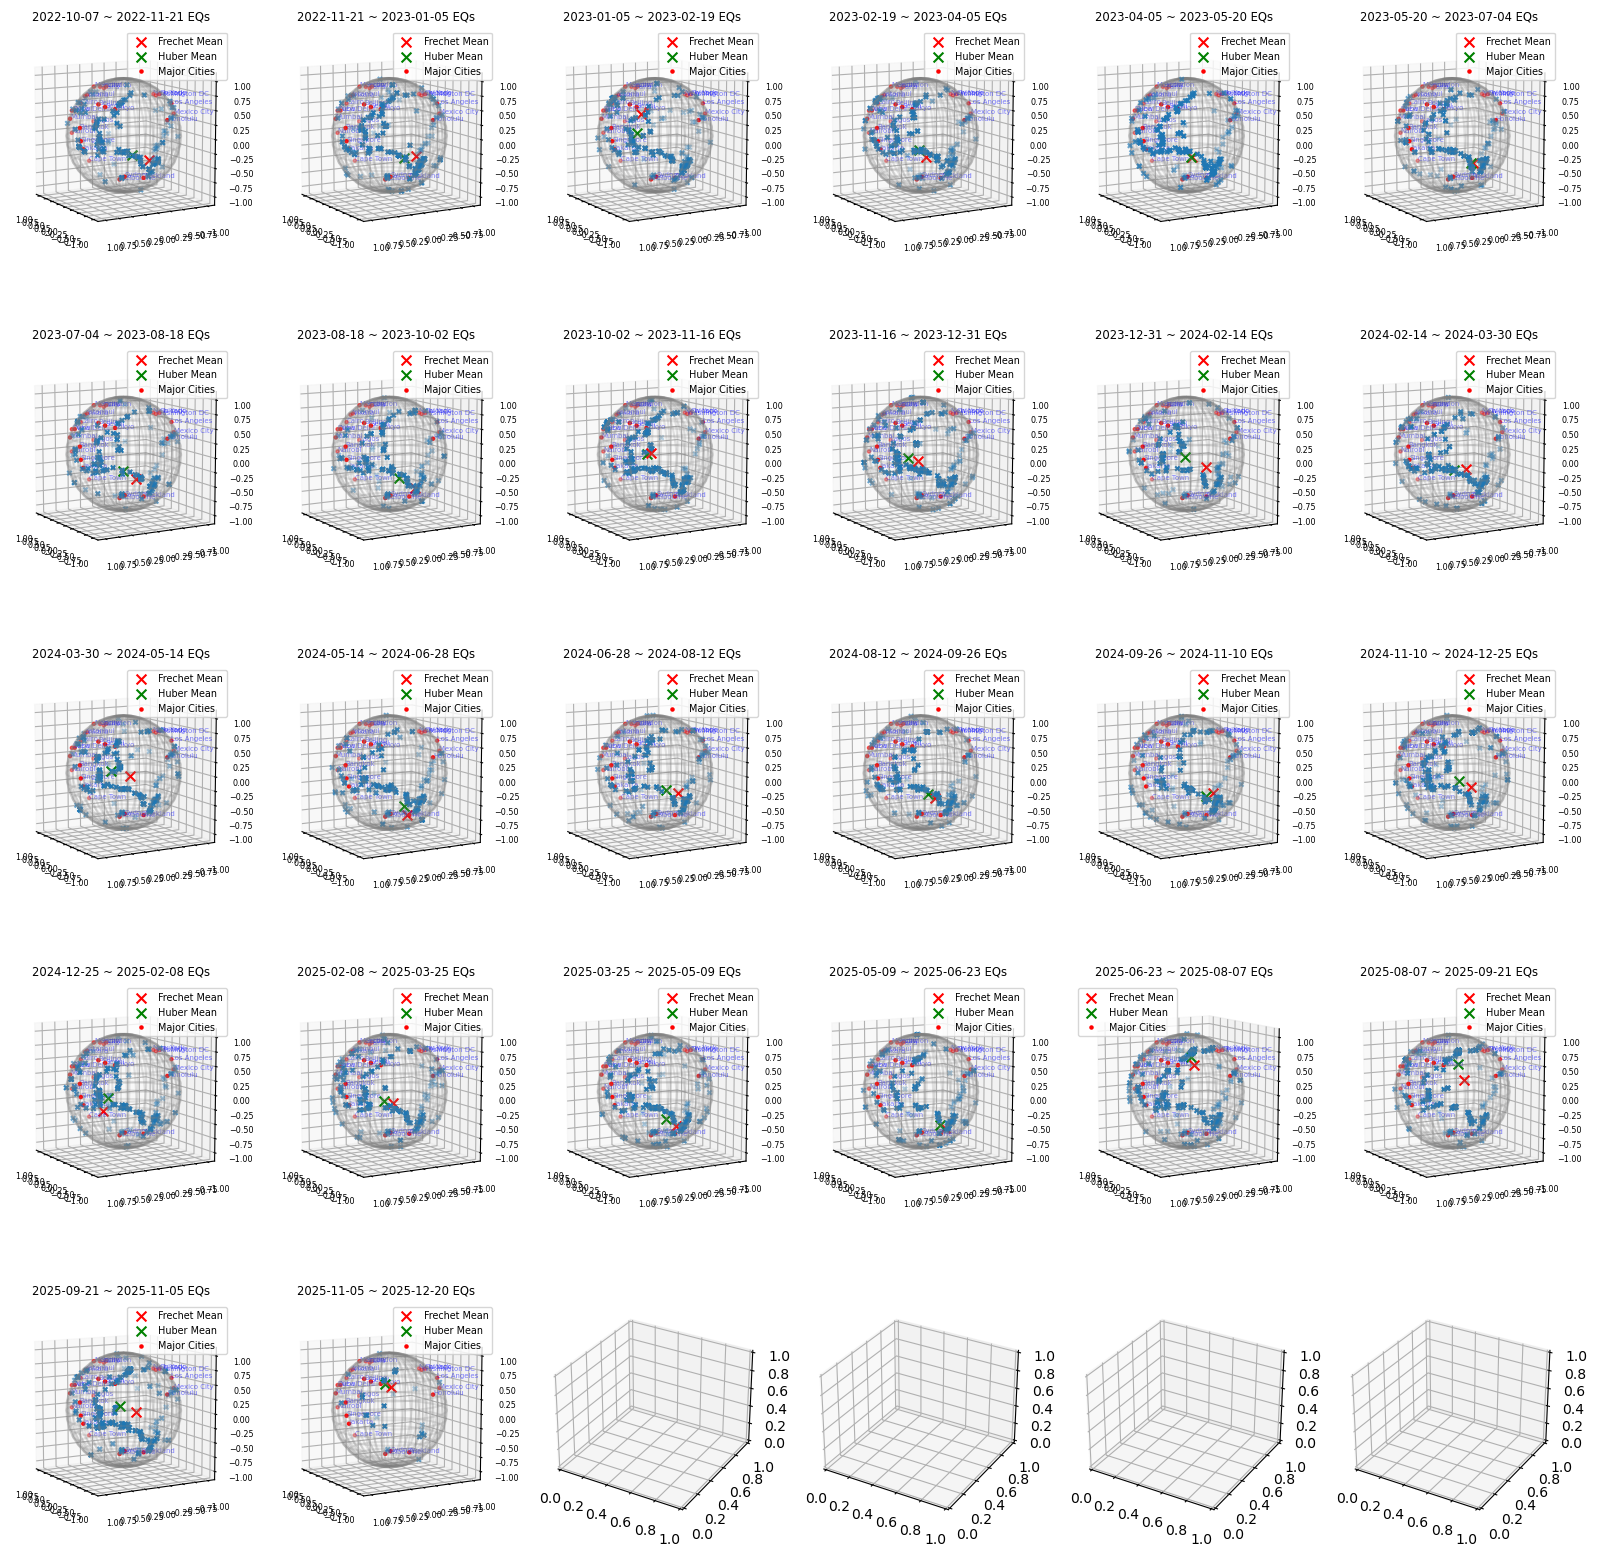

In [ ]:
# === geomstats 구면 시각화 ===
sphere = Hypersphere(dim=2)
viz = Sphere()

fig, ax = plt.subplots(5,6, figsize=(20, 20), subplot_kw={"projection": "3d"})
# ax = fig.add_subplot(111, projection="3d")
# ax[axc].view_init(elev=10, azim=150) 
lastday = datetime.now(timezone.utc)-timedelta(days=7)  #datetime.now(timezone.utc)
maxd = 1130
dp = 45
# 날짜별 지점 점으로 표시
mean_result = []
for i,d in enumerate(range(0,maxd,dp)):
    axc = (i//6, i%6)
    # 구면 전체 표시 (wireframe)
    viz.draw(ax=ax[axc], color='lightgray', alpha=0.2)

    dateFrom = lastday - timedelta(days=maxd-d)  
    dateTo = lastday - timedelta(days=maxd-d-dp)
    mask = (df_world['time_utc'] >= dateFrom) & (df_world['time_utc'] < dateTo) & (df_world.mag>=5)& (df_world.mag<=30)
    print(i,d, dateFrom, dateTo, mask.sum())
    df_world_t = df_world.loc[mask].reset_index(drop=True)
    ax[axc].scatter(df_world_t['x'],df_world_t['y'],df_world_t['z'],
            s=10, marker='x', ) #label=f'Last {maxd-i} days'
    
    d1 = df_world_t.loc[:,['x','y','z']].to_numpy()
    
    pd1 = sphere.metric.dist_pairwise(d1)
    rx, cx = np.triu_indices(pd1.shape[0])
    upper_pd1 = pd1[rx, cx]**2

    mean_obs, var_obs = np.mean(upper_pd1),np.var(upper_pd1,ddof=1)
    d_eff_est = (2 * mean_obs**2) / var_obs
    # 공식: sigma^2 = E / (2 * d_eff)
    sigma_sq_est = mean_obs / (2 * d_eff_est)
    #rho_sq_est = (var_obs/4)/mean_obs
    cutoff_ = 0.7*np.sqrt(sigma_sq_est)
    #cutoff_ = 1.187*np.sqrt(sigma_sq_est)
    print(cutoff_)

#     print('fm')
    fm = FrechetMean(sphere)
    fm.set(max_iter=4096,epsilon=1e-7,init_point=d1[30])
    fm.fit(d1)
    ax[axc].scatter(*fm.estimate_,marker='x',c="red", s=50, label="Frechet Mean")
#     print('mest')
    mest = rrm.RiemannianRobustMestimator(space=sphere,method='adaptive',
                                          critical_value=cutoff_,m_estimator='huber',init_point_method='mean-projection')
    mest.set(max_iter=4096,epsilon=1e-7)
    mest.fit(d1)
    ax[axc].scatter(*mest.estimate_.x,marker='x',c="green", s=50, label="Huber Mean")

    mean_result.append((dateFrom,dateTo,fm.estimate_,mest.estimate_.x))

    # 도시 점 찍기
    ax[axc].scatter(points[:,0], points[:,1], points[:,2],
            c="red", s=5, label="Major Cities")

    # 도시 이름 라벨
    for j, name in enumerate(names):
        ax[axc].text(points[j,0], points[j,1], points[j,2],
                name, fontsize=5, color="blue",alpha=0.5)
        
    #ax[i].set_title(f"Last {maxd-d}~{maxd-d-dp} days Earthquakes")
    ax[axc].set_title(f"{str(dateFrom)[:10]} ~ {str(dateTo)[:10]} EQs",fontsize='small')
    ax[axc].view_init(elev=10, azim=150) 
    ax[axc].legend(fontsize='x-small')
    ax[axc].tick_params(labelsize='xx-small')
# plt.tight_layout()
plt.show()

In [45]:
md1 = pd.DataFrame(mean_result,columns = ['dateFrom','dateTo','Frechet','Huber'])
gs.array(md1['Frechet'].tolist())[:,0]

array([-0.96100165, -0.97909874, -0.59959198, -0.89269953, -0.89165697,
       -0.93661644, -0.91834112, -0.90064785, -0.81327529, -0.83609895,
       -0.98052491, -0.95316423, -0.90493027, -0.79104292, -0.97373221,
       -0.9299108 , -0.97871021, -0.97548067, -0.62871477, -0.89660354,
       -0.88657737, -0.86800841, -0.7512623 , -0.88740041, -0.94011354,
       -0.74476272])

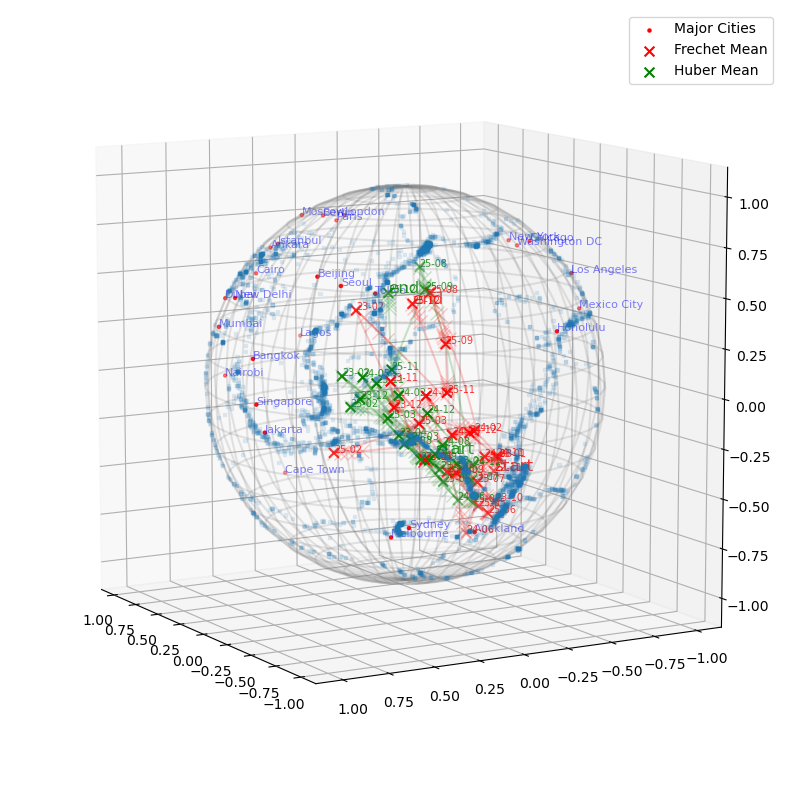

In [46]:
sphere = Hypersphere(dim=2)
fig, ax = plt.subplots(1,1, figsize=(10, 10), subplot_kw={"projection": "3d"})

viz = Sphere()
viz.draw(ax=ax, color='lightgray', alpha=0.2)
# 도시 점 찍기
ax.scatter(points[:,0], points[:,1], points[:,2],
        c="red", s=5, label="Major Cities")

# 도시 이름 라벨
for j, name in enumerate(names):
    ax.text(points[j,0], points[j,1], points[j,2],
            name, fontsize=8, color="blue",alpha=0.5)

df_world_t = df_world.loc[df_world.mag>=5].reset_index(drop=True)
ax.scatter(df_world_t['x'],df_world_t['y'],df_world_t['z'],
            s=5, alpha=0.1, marker='s', )

md1 = pd.DataFrame(mean_result,columns = ['dateFrom','dateTo','Frechet','Huber'])
fms = gs.array(md1['Frechet'].tolist())
mests = gs.array(md1['Huber'].tolist())
ax.scatter(fms[:,0],fms[:,1],fms[:,2],
           marker='x',c="red", s=50, label="Frechet Mean")
ax.scatter(mests[:,0],mests[:,1],mests[:,2],
           marker='x',c="green", s=50, label="Huber Mean")
           
for j, r in md1.iterrows():
    s = str(r['dateTo'])[2:7]
    fm = r['Frechet']
    mest = r['Huber']
    ax.text(fm[0], fm[1], fm[2],
            s, fontsize=7, color="red",alpha=0.8)
    ax.text(mest[0], mest[1], mest[2],
            s, fontsize=7, color="green",alpha=0.8)
    if j==0:
        ax.text(fm[0], fm[1], fm[2],
            'start', fontsize=12, color="red",alpha=0.8)
        ax.text(mest[0], mest[1], mest[2],
            'start', fontsize=12, color="green",alpha=0.8)
    if j==len(md1)-1:
        ax.text(fm[0], fm[1], fm[2],
            'end', fontsize=12, color="red",alpha=0.8)
        ax.text(mest[0], mest[1], mest[2],
            'end', fontsize=12, color="green",alpha=0.8)

t = np.linspace(0,1,20)
for i in range(len(md1)-1):
    gds_fm = sphere.metric.geodesic(md1['Frechet'][i],md1['Frechet'][i+1])
    gds_mest = sphere.metric.geodesic(md1['Huber'][i],md1['Huber'][i+1])
    gds_fm = gds_fm(t)
    gds_mest = gds_mest(t)
    ax.plot(gds_fm[:,0],gds_fm[:,1],gds_fm[:,2],'-',c="red",alpha=0.2)
    ax.plot(gds_mest[:,0],gds_mest[:,1],gds_mest[:,2],'-',c="green",alpha=0.2)
    ax.plot(gds_fm[-5:,0],gds_fm[-5:,1],gds_fm[-5:,2],'x',c="red",markersize=10,alpha=0.2)  #,0],gds_fm[-5:,1],gds_fm[-5:,2]
    ax.plot(gds_mest[-5:,0],gds_mest[-5:,1],gds_mest[-5:,2],'x',c="green",markersize=10,alpha=0.2)  #,0],gds_mest[-5:,1],gds_mest[-5:,2]
#     ax.scatter(mests[:,0],mests[:,1],mests[:,2],
#                 marker='x',c="green", s=50, label="Huber Mean")

#     ax.annotate3d(f"{i+1}", xy=md1['Frechet'][i], xytext=md1['Frechet'][i+1],
#             arrowprops=dict(facecolor='gray', shrink=0.05))
#     ax.annotate3d(f"{i+1}", xy=md1['Huber'][i], xytext=md1['Huber'][i+1],
#             arrowprops=dict(facecolor='gray', shrink=0.05))
ax.view_init(elev=10, azim=150) 
ax.legend()

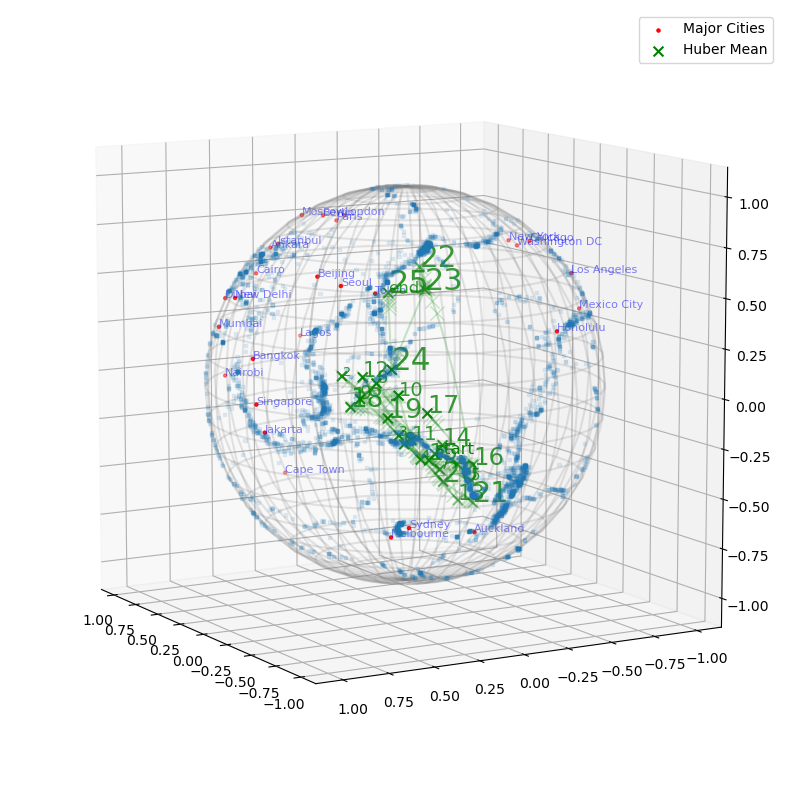

In [48]:
sphere = Hypersphere(dim=2)
fig, ax = plt.subplots(1,1, figsize=(10, 10), subplot_kw={"projection": "3d"})

viz = Sphere()
viz.draw(ax=ax, color='lightgray', alpha=0.2)
# 도시 점 찍기
ax.scatter(points[:,0], points[:,1], points[:,2],
        c="red", s=5, label="Major Cities")

# 도시 이름 라벨
for j, name in enumerate(names):
    ax.text(points[j,0], points[j,1], points[j,2],
            name, fontsize=8, color="blue",alpha=0.5)

df_world_t = df_world.loc[df_world.mag>=5].reset_index(drop=True)
ax.scatter(df_world_t['x'],df_world_t['y'],df_world_t['z'],
            s=5, alpha=0.1, marker='s', )

md1 = pd.DataFrame(mean_result,columns = ['dateFrom','dateTo','Frechet','Huber'])
# fms = gs.array(md1['Frechet'].tolist())
# ax.scatter(fms[:,0],fms[:,1],fms[:,2],
#            marker='x',c="red", s=50, label="Frechet Mean")
mests = gs.array(md1['Huber'].tolist())
ax.scatter(mests[:,0],mests[:,1],mests[:,2],
           marker='x',c="green", s=50, label="Huber Mean")
           
for j, r in md1.iterrows():
    s = str(int(j)) #+':'+str(r['dateTo'])[2:7]
    # fm = r['Frechet']
    mest = r['Huber']
    # ax.text(fm[0], fm[1], fm[2],
    #         s, fontsize=7, color="red",alpha=0.8)
    ax.text(mest[0], mest[1], mest[2],
            s, fontsize=max(int(s)*0.6+8,8) , color="green",alpha=0.8)
    if j==0:
        # ax.text(fm[0], fm[1], fm[2],
        #     'start', fontsize=max(int(s)*0.6+8,8), color="red",alpha=0.8)
        ax.text(mest[0], mest[1], mest[2],
            'start', fontsize=12, color="green",alpha=1)
    if j==len(md1)-1:
        # ax.text(fm[0], fm[1], fm[2],
        #     'end', fontsize=12, color="red",alpha=0.8)
        ax.text(mest[0], mest[1], mest[2],
            'end', fontsize=12, color="green",alpha=0.8)

t = np.linspace(0,1,20)
for i in range(len(md1)-1):
    # gds_fm = sphere.metric.geodesic(md1['Frechet'][i],md1['Frechet'][i+1])
    # gds_fm = gds_fm(t)
    # ax.plot(gds_fm[:,0],gds_fm[:,1],gds_fm[:,2],'-',c="red",alpha=0.2)
    # ax.plot(gds_fm[-5:,0],gds_fm[-5:,1],gds_fm[-5:,2],'x',c="red",markersize=10,alpha=0.2)  #,0],gds_fm[-5:,1],gds_fm[-5:,2]
    gds_mest = sphere.metric.geodesic(md1['Huber'][i],md1['Huber'][i+1])
    gds_mest = gds_mest(t)
    ax.plot(gds_mest[:,0],gds_mest[:,1],gds_mest[:,2],'-',c="green",alpha=0.2)
    ax.plot(gds_mest[-5:,0],gds_mest[-5:,1],gds_mest[-5:,2],'x',c="green",markersize=10,alpha=0.2)  #,0],gds_mest[-5:,1],gds_mest[-5:,2]

ax.view_init(elev=10, azim=150) 
ax.legend()

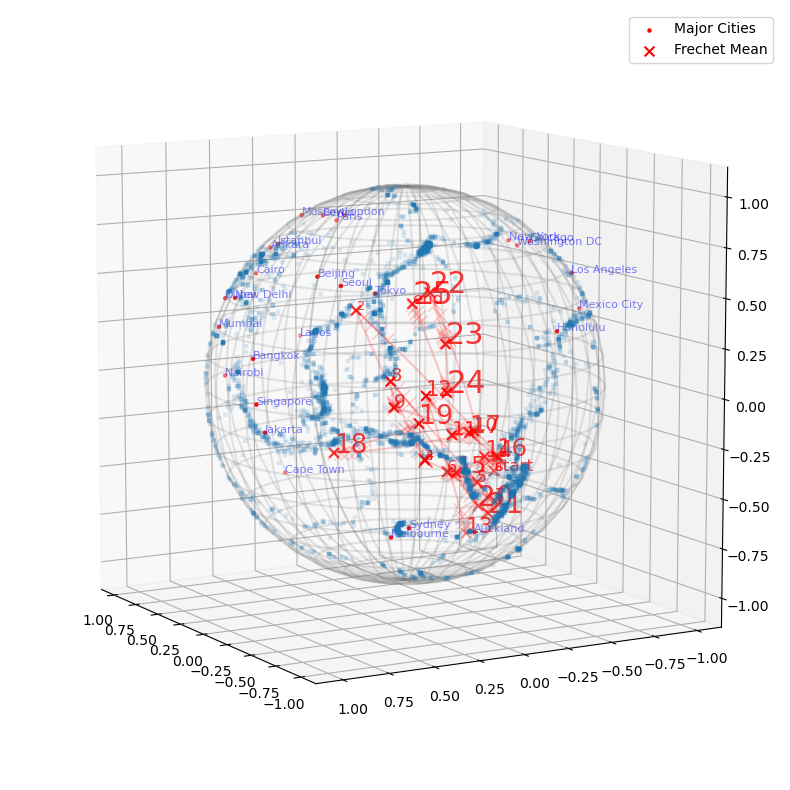

In [47]:
sphere = Hypersphere(dim=2)
fig, ax = plt.subplots(1,1, figsize=(10, 10), subplot_kw={"projection": "3d"})

viz = Sphere()
viz.draw(ax=ax, color='lightgray', alpha=0.2)
# 도시 점 찍기
ax.scatter(points[:,0], points[:,1], points[:,2],
        c="red", s=5, label="Major Cities")

# 도시 이름 라벨
for j, name in enumerate(names):
    ax.text(points[j,0], points[j,1], points[j,2],
            name, fontsize=8, color="blue",alpha=0.5)

df_world_t = df_world.loc[df_world.mag>=5].reset_index(drop=True)
ax.scatter(df_world_t['x'],df_world_t['y'],df_world_t['z'],
            s=5, alpha=0.1, marker='s', )

md1 = pd.DataFrame(mean_result,columns = ['dateFrom','dateTo','Frechet','Huber'])
fms = gs.array(md1['Frechet'].tolist())
ax.scatter(fms[:,0],fms[:,1],fms[:,2],
           marker='x',c="red", s=50, label="Frechet Mean")
# mests = gs.array(md1['Huber'].tolist())
# ax.scatter(mests[:,0],mests[:,1],mests[:,2],
#            marker='x',c="green", s=50, label="Huber Mean")
           
for j, r in md1.iterrows():
    s = str(int(j)) #+':'+str(r['dateTo'])[2:7]
    fm = r['Frechet']
    # mest = r['Huber']
    ax.text(fm[0], fm[1], fm[2],
            s, fontsize=max(int(s)*0.6+8,8), color="red",alpha=0.8)
    # ax.text(mest[0], mest[1], mest[2],
    #         s, fontsize=max(int(s)*0.6+8,8) , color="green",alpha=0.8)
    if j==0:
        ax.text(fm[0], fm[1], fm[2],
            'start', fontsize=12, color="red",alpha=0.8)
        # ax.text(mest[0], mest[1], mest[2],
        #     'start', fontsize=12, color="green",alpha=1)
    if j==len(md1)-1:
        ax.text(fm[0], fm[1], fm[2],
            'end', fontsize=12, color="red",alpha=0.8)
        # ax.text(mest[0], mest[1], mest[2],
        #     'end', fontsize=12, color="green",alpha=0.8)

t = np.linspace(0,1,20)
for i in range(len(md1)-1):
    gds_fm = sphere.metric.geodesic(md1['Frechet'][i],md1['Frechet'][i+1])
    gds_fm = gds_fm(t)
    ax.plot(gds_fm[:,0],gds_fm[:,1],gds_fm[:,2],'-',c="red",alpha=0.2)
    ax.plot(gds_fm[-5:,0],gds_fm[-5:,1],gds_fm[-5:,2],'x',c="red",markersize=10,alpha=0.2)  #,0],gds_fm[-5:,1],gds_fm[-5:,2]
    # gds_mest = sphere.metric.geodesic(md1['Huber'][i],md1['Huber'][i+1])
    # gds_mest = gds_mest(t)
    # ax.plot(gds_mest[:,0],gds_mest[:,1],gds_mest[:,2],'-',c="green",alpha=0.2)
    # ax.plot(gds_mest[-5:,0],gds_mest[-5:,1],gds_mest[-5:,2],'x',c="green",markersize=10,alpha=0.2)  #,0],gds_mest[-5:,1],gds_mest[-5:,2]

ax.view_init(elev=10, azim=150) 
ax.legend()

In [49]:
for i in range(len(mean_result)):
    city_distfrom_m = sphere.metric.dist(cities_1m.loc[:,['x','y','z']].to_numpy(),mean_result[i][2])
    mindist = city_distfrom_m.min()
    mindist_i = np.where(city_distfrom_m==mindist)[0]
    print('fm',i,str(mean_result[i][1])[2:7],cities_1m['name'][mindist_i].tolist()[0],round(mindist*6400,2),'km')


fm 0 22-11 Fiji_Suva 367.86 km
fm 1 23-01 Fiji_Suva 766.4 km
fm 2 23-02 Japan_Miyazaki 301.69 km
fm 3 23-04 Papua New Guinea_Port Moresby 923.96 km
fm 4 23-05 Papua New Guinea_Port Moresby 920.18 km
fm 5 23-07 Fiji_Suva 750.48 km
fm 6 23-08 Australia_Brisbane 1672.63 km
fm 7 23-10 Fiji_Suva 848.88 km
fm 8 23-11 Indonesia_Jayapura 1600.52 km
fm 9 23-12 Indonesia_Jayapura 980.78 km
fm 10 24-02 Fiji_Suva 1931.03 km
fm 11 24-03 Papua New Guinea_Lae 1790.04 km
fm 12 24-05 Papua New Guinea_Lae 1802.53 km
fm 13 24-06 New Zealand_Auckland 286.29 km
fm 14 24-08 Fiji_Suva 1004.04 km
fm 15 24-09 Fiji_Suva 1512.45 km
fm 16 24-11 Fiji_Suva 794.21 km
fm 17 24-12 Fiji_Suva 1968.79 km
fm 18 25-02 East Timor_Dili 466.99 km
fm 19 25-03 Papua New Guinea_Lae 1005.71 km
fm 20 25-05 Fiji_Suva 1107.35 km
fm 21 25-06 New Zealand_Takapuna 832.92 km
fm 22 25-08 Japan_Kushiro 1427.57 km
fm 23 25-09 Japan_Mito 2699.87 km
fm 24 25-11 Papua New Guinea_Lae 2274.95 km
fm 25 25-12 Japan_Iwaki 1149.53 km


In [50]:

for i in range(len(mean_result)):
    city_distfrom_m = sphere.metric.dist(cities_1m.loc[:,['x','y','z']].to_numpy(),mean_result[i][3])
    mindist = city_distfrom_m.min()
    mindist_i = np.where(city_distfrom_m==mindist)[0]
    print('m_estimator(Huber)',i,str(mean_result[i][1])[2:7],cities_1m['name'][mindist_i].tolist()[0],round(mindist*6400,2),'km')

m_estimator(Huber) 0 22-11 Papua New Guinea_Port Moresby 1214.9 km
m_estimator(Huber) 1 23-01 Fiji_Suva 1588.35 km
m_estimator(Huber) 2 23-02 Philippines_Tacloban 765.05 km
m_estimator(Huber) 3 23-04 Papua New Guinea_Lae 327.68 km
m_estimator(Huber) 4 23-05 Papua New Guinea_Port Moresby 795.95 km
m_estimator(Huber) 5 23-07 Fiji_Suva 967.33 km
m_estimator(Huber) 6 23-08 Papua New Guinea_Lae 296.47 km
m_estimator(Huber) 7 23-10 Papua New Guinea_Port Moresby 1469.11 km
m_estimator(Huber) 8 23-11 Indonesia_Biak 1430.33 km
m_estimator(Huber) 9 23-12 Indonesia_Biak 792.22 km
m_estimator(Huber) 10 24-02 Indonesia_Jayapura 1345.93 km
m_estimator(Huber) 11 24-03 Papua New Guinea_Lae 539.05 km
m_estimator(Huber) 12 24-05 Philippines_Butuan 1403.85 km
m_estimator(Huber) 13 24-06 Australia_Gold Coast 1331.91 km
m_estimator(Huber) 14 24-08 Papua New Guinea_Port Moresby 1473.71 km
m_estimator(Huber) 15 24-09 Papua New Guinea_Port Moresby 1050.9 km
m_estimator(Huber) 16 24-11 Fiji_Suva 1112.31 km
m_e